In [1]:
import librosa
import os
import json
import pickle
import zipfile
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense, Activation, BatchNormalization
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

In [2]:
paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('train/audio') for f in fn if f[-4:]=='.wav']
paths = pd.DataFrame(paths, columns=['path']) # .sample(n=1000).reset_index(drop=True)
paths['label'] = paths['path'].apply(lambda x: x.split('/')[-2])
paths

,path,label
0,train/audio\bed\00176480_nohash_0.wav,train
1,train/audio\bed\004ae714_nohash_0.wav,train
2,train/audio\bed\004ae714_nohash_1.wav,train
3,train/audio\bed\00f0204f_nohash_0.wav,train
4,train/audio\bed\00f0204f_nohash_1.wav,train
...,...,...
64722,train/audio\_background_noise_\dude_miaowing.wav,train
64723,train/audio\_background_noise_\exercise_bike.wav,train
64724,train/audio\_background_noise_\pink_noise.wav,train
64725,train/audio\_background_noise_\running_tap.wav,train


In [3]:
def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float) 

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows(), total = df.shape[0]):
        x = audio2mel(row['path'])
        X.append(x.transpose())
    X = np.array(X) 
    return X
#os.chdir('/content/drive/MyDrive/DL3/')
if os.path.exists('X_train.npy') and os.path.exists('y_train.npy') and os.path.exists('class_names.npy'):
  X = np.load('X_train.npy', allow_pickle=True)
  y = np.load('y_train.npy', allow_pickle=True)
  classess = np.load('class_names.npy', allow_pickle=True)
else:
  X = convert_wav_to_image(paths)
  enc = OneHotEncoder() 
  y = enc.fit_transform(paths[['label']]).todense()
  classes = enc.get_feature_names()
  np.save('X_train.npy', X)
  np.save('y_train.npy', y)
  np.save('class_names.npy', classes)
X = (X - np.mean(X))/np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [18]:
model = Sequential()
model.add(BatchNormalization())
model.add(SimpleRNN(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(128))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])

Epoch 1/30
949/949 [==============================] - 45s 41ms/step - loss: 3.6862 - accuracy: 0.0413 - val_loss: 3.4162 - val_accuracy: 0.0447
Epoch 2/30
949/949 [==============================] - 37s 39ms/step - loss: 3.3937 - accuracy: 0.0545 - val_loss: 3.1752 - val_accuracy: 0.0845
Epoch 3/30
949/949 [==============================] - 36s 38ms/step - loss: 3.2937 - accuracy: 0.0663 - val_loss: 3.3732 - val_accuracy: 0.0460
Epoch 4/30
949/949 [==============================] - 37s 39ms/step - loss: 3.3613 - accuracy: 0.0582 - val_loss: 3.4040 - val_accuracy: 0.0561
Epoch 5/30
949/949 [==============================] - 37s 39ms/step - loss: 3.3440 - accuracy: 0.0559 - val_loss: 3.3303 - val_accuracy: 0.0687


<AxesSubplot:>

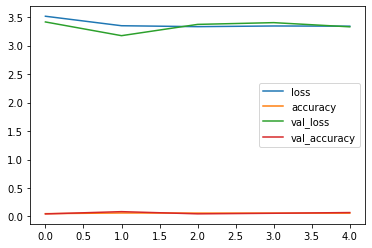

In [20]:
pd.DataFrame(history.history).plot()

In [21]:
def accuracy(model):
    p = model.predict(X_test)
    return np.mean(np.argmax(p,1) == np.argmax(y_test,1))
accuracy(model)

0.06320224719101124

Epoch 1/30
949/949 [==============================] - 55s 51ms/step - loss: 3.7612 - accuracy: 0.0446 - val_loss: 3.3860 - val_accuracy: 0.0512
Epoch 2/30
949/949 [==============================] - 47s 50ms/step - loss: 3.4943 - accuracy: 0.0468 - val_loss: 3.3627 - val_accuracy: 0.0600
Epoch 3/30
949/949 [==============================] - 48s 51ms/step - loss: 3.3781 - accuracy: 0.0553 - val_loss: 3.2303 - val_accuracy: 0.0688
Epoch 4/30
949/949 [==============================] - 49s 52ms/step - loss: 3.4127 - accuracy: 0.0465 - val_loss: 3.2736 - val_accuracy: 0.0617
Epoch 5/30
949/949 [==============================] - 50s 52ms/step - loss: 3.3062 - accuracy: 0.0624 - val_loss: 3.3847 - val_accuracy: 0.0505
Epoch 6/30
949/949 [==============================] - 51s 53ms/step - loss: 3.3439 - accuracy: 0.0574 - val_loss: 3.3134 - val_accuracy: 0.0594


0.06259363295880149

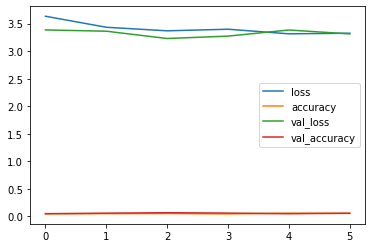

In [22]:
model2 = Sequential()
model2.add(BatchNormalization())
model2.add(SimpleRNN(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model2.add(Dropout(0.5))
model2.add(SimpleRNN(128, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(SimpleRNN(256))
model2.add(Dense(256))
model2.add(Dropout(0.5))
model2.add(Dense(y.shape[1]))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])

pd.DataFrame(history2.history).plot()

accuracy(model2)